# Loan Payback Prediction

**Playground Series - Season 5, Episode 11**

This notebook predicts whether a loan will be paid back based on borrower characteristics and loan details.

## Project Overview

This project explores various machine learning approaches to predict loan repayment. The final solution uses a meta-model ensemble approach that combines predictions from multiple gradient boosting models (CatBoost, LightGBM, and XGBoost) to achieve improved performance.

### Key Findings and Challenges

**Feature Engineering:** Extensive feature engineering was attempted (ratio features, multiplication features), but these new features did not improve model performance. Instead, they introduced noise and led to overfitting. The final solution uses only basic transformations: square root and logarithmic transformations for normalization, along with standard encoding and scaling.

**Ensemble Methods:** Both stacking and blending approaches were tested, but they performed poorly and worsened results compared to individual base models. The meta-model approach (using a second-level model to learn how to combine base model predictions) proved to be the most effective strategy.

**Model Selection:** Only the three strongest base models were included in the final ensemble:
- CatBoost (0.9226 ROC AUC) - best individual model
- LightGBM (0.9222 ROC AUC)
- XGBoost (0.9203 ROC AUC)

Random Forest was excluded as it performed significantly worse (0.9136 ROC AUC) and was dragging down ensemble performance.

**Hyperparameter Tuning:** CatBoost was tested with hyperparameter tuning, but default parameters showed better results. More extensive tuning could potentially improve results but requires significant computational time (1-2 hours), so default parameters were used in the final version.

**Final Result:** The meta-model achieved 0.9230 ROC AUC on validation set, improving from the best base model (0.9226), which translated to top 25% ranking in the competition.

## Imports and Setup

Import all necessary libraries for data processing, modeling, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RandomizedSearchCV,
    cross_val_predict
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    roc_curve, 
    f1_score,
    confusion_matrix, 
    classification_report, 
    make_scorer, 
    recall_score
)
from sklearn.base import BaseEstimator, TransformerMixin


## Data Loading

Load and explore the training and test datasets.


In [2]:
X = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')

X.drop(columns='id', inplace=True)
index_test = X_test['id']
X_test.drop(columns='id', inplace=True)

y = X['loan_paid_back']
X.drop(columns='loan_paid_back', inplace=True)

X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 49.9+ MB


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1


In [3]:
X.describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345
std,26711.942078,0.068573,55.424956,6926.530568,2.008959
min,6002.430000,0.011000,395.000000,500.090000,3.200000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000


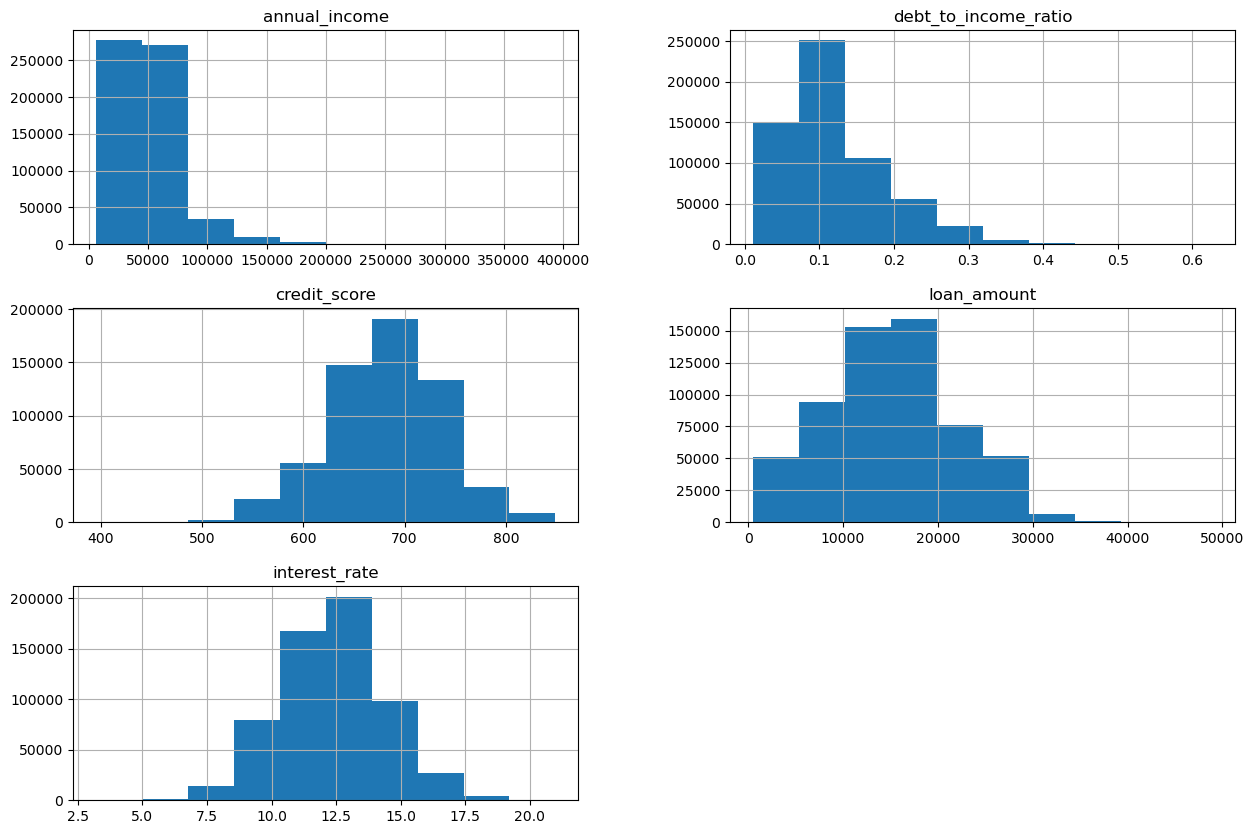

In [4]:
X.hist(figsize=(15, 10))
plt.show()



## Exploratory Data Analysis (EDA)

Perform comprehensive exploratory data analysis to understand the relationships between features and the target variable.


### Correlation Matrix

Check for multicollinearity among numerical features. High correlations between features can indicate redundant information.


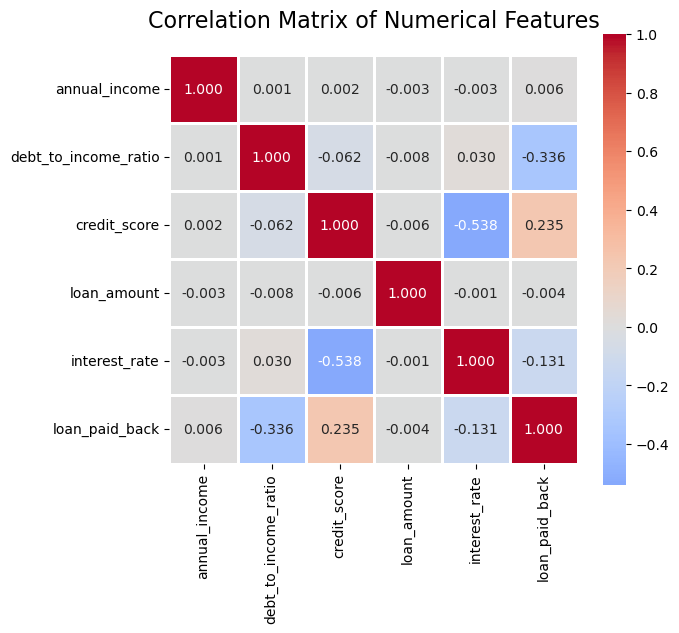


No really high correlations found. Only medium strong between interest_rate and credit_score. So multicollinearity is not a major concern.


In [ ]:
X_with_target = X.copy()
X_with_target['loan_paid_back'] = y

numerical_features = X_with_target.select_dtypes(include=[np.number]).columns

corr_matrix = X_with_target[numerical_features].corr()

plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()
print("\nNo really high correlations found. Only medium strong between interest_rate and credit_score. So multicollinearity is not a major concern.")


### Target Analysis

Analyze how features differ between borrowers who paid back loans versus those who did not. This helps identify the most predictive features.


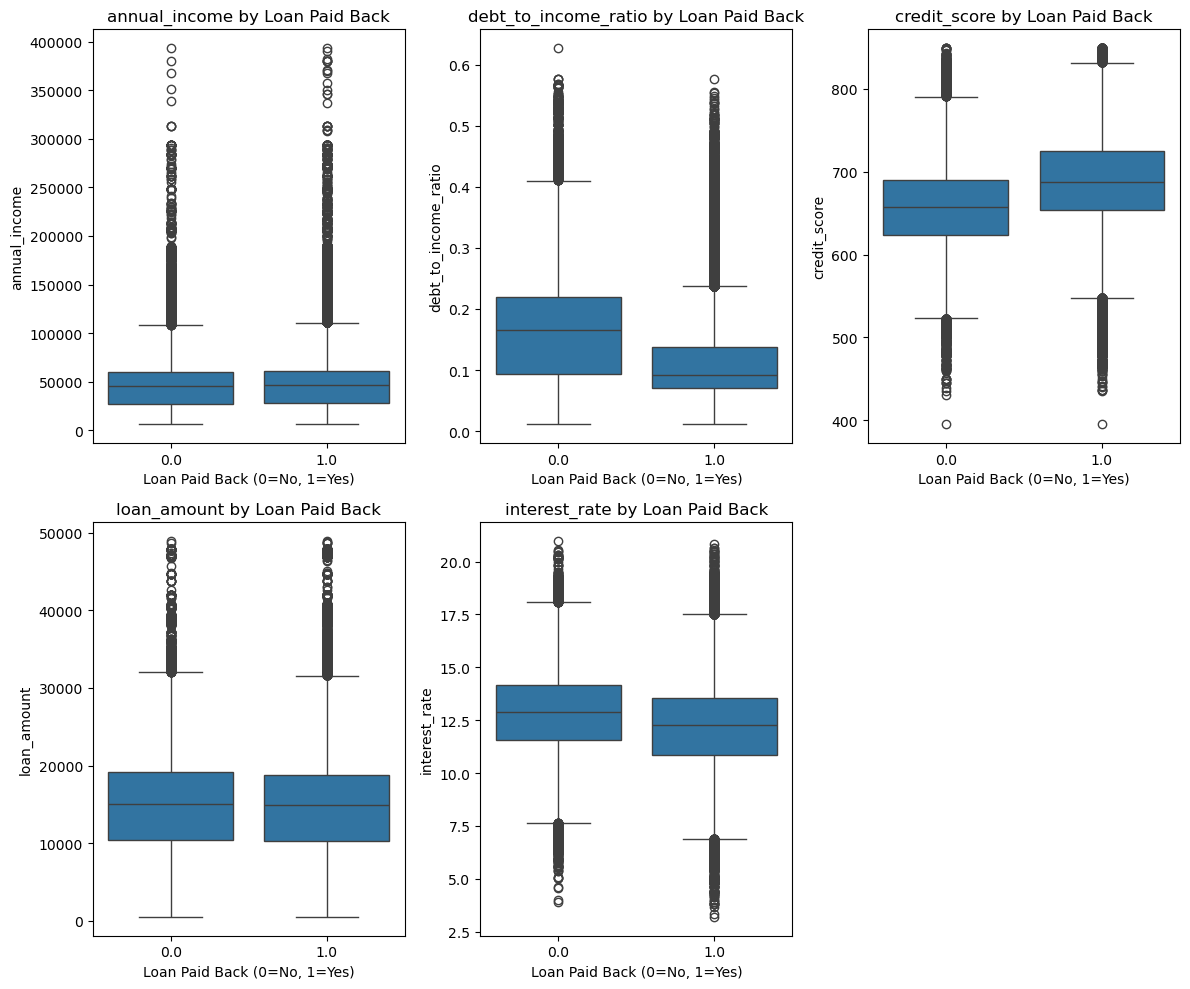

In [ ]:

X_with_target = X.copy()
X_with_target['loan_paid_back'] = y

numerical_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 
                  'loan_amount', 'interest_rate']

fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.boxplot(data=X_with_target, x='loan_paid_back', y=col, ax=axes[idx])
    axes[idx].set_title(f'{col} by Loan Paid Back', fontsize=12)
    axes[idx].set_xlabel('Loan Paid Back (0=No, 1=Yes)', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()


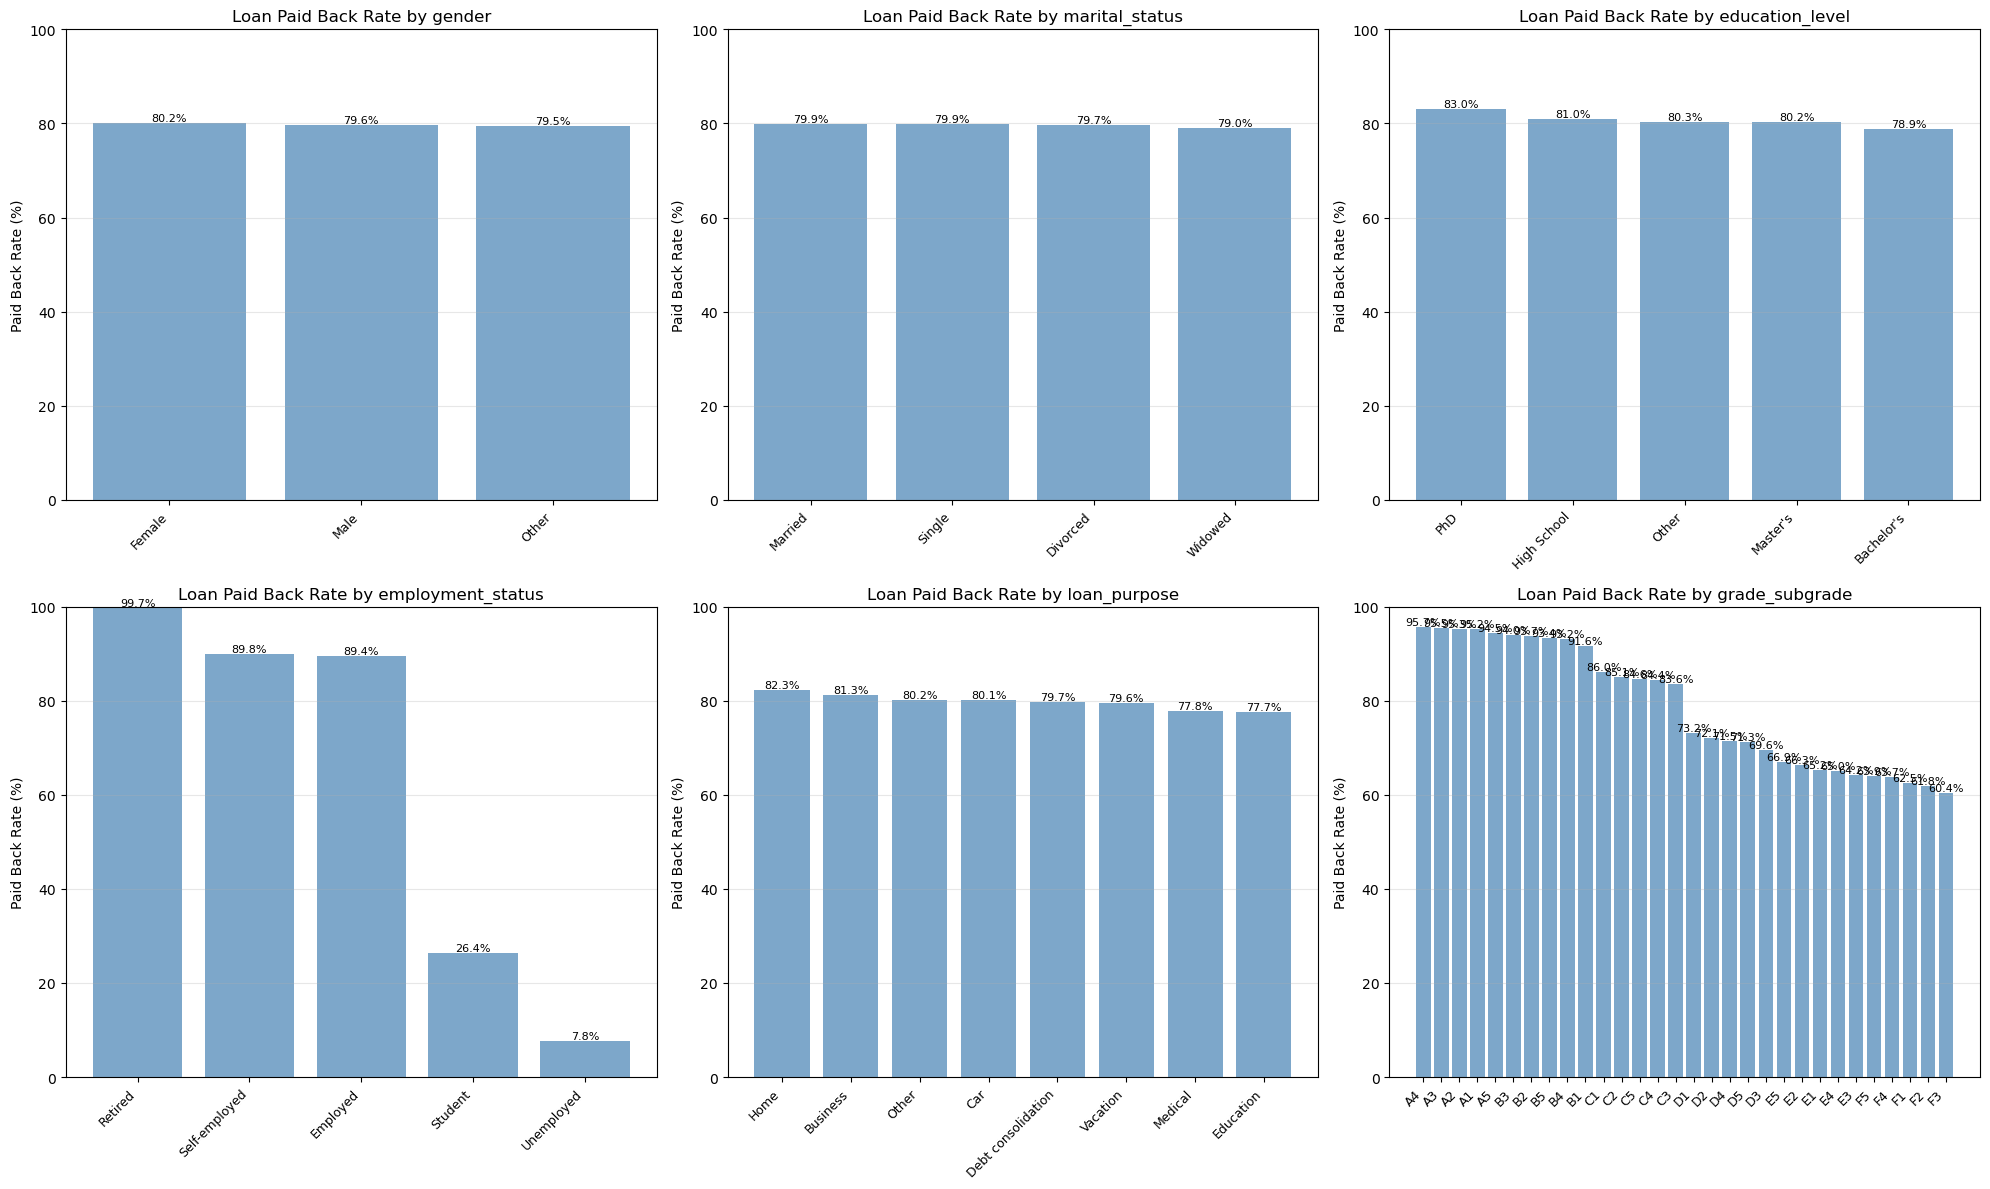

In [ ]:
# Categorical features: Create barplots showing loan_paid_back rate by category
categorical_cols = ['gender', 'marital_status', 'education_level', 
                    'employment_status', 'loan_purpose', 'grade_subgrade']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    category_paid = X_with_target.groupby(col)['loan_paid_back'].mean() * 100
    category_paid = category_paid.sort_values(ascending=False)
    
    bars = axes[idx].bar(range(len(category_paid)), category_paid.values, 
                         color='steelblue', alpha=0.7)
    axes[idx].set_xticks(range(len(category_paid)))
    axes[idx].set_xticklabels(category_paid.index, rotation=45, ha='right', fontsize=9)
    axes[idx].set_title(f'Loan Paid Back Rate by {col}', fontsize=12)
    axes[idx].set_ylabel('Paid Back Rate (%)', fontsize=10)
    axes[idx].set_ylim([0, 100])
    axes[idx].grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### EDA Insights

**Key Findings:**

1. **Numerical Features Distribution:** The boxplots reveal distinct distribution patterns between borrowers who repaid loans versus those who defaulted. Credit score shows the most pronounced difference, with repaid loans typically having higher median values. Annual income and debt-to-income ratio also exhibit meaningful differences in their distributions, suggesting these features contain predictive information for loan repayment.

2. **Loan Terms Impact:** Interest rate and loan amount distributions differ between the two groups, indicating that loan terms play a role in repayment behavior. The relationship between these features and loan outcome will be captured by the machine learning models.

3. **Categorical Features Patterns:** The barplots demonstrate varying repayment rates across different categories. Some categorical features (such as employment status, education level, and loan grade/subgrade) show more pronounced differences in repayment rates between categories, suggesting they may be important predictors. Gender and marital status show relatively smaller differences, indicating they may have less predictive power.

4. **Feature Relationships:** The correlation matrix analysis indicates that numerical features are not highly correlated with each other (no correlations above 0.7 in absolute value), which means there is no severe multicollinearity. This allows us to use all features in the model without concerns about redundant information or numerical instability.

5. **Modeling Implications:** The EDA suggests that both numerical and categorical features contain valuable information for predicting loan repayment. The combination of financial characteristics (income, debt ratio, credit score) and loan terms (amount, interest rate) along with borrower demographics and loan grades should provide a comprehensive predictive signal.


## Data Preprocessing and Feature Engineering

Split data into train/validation sets and explore feature distributions. Create custom transformers for feature engineering.

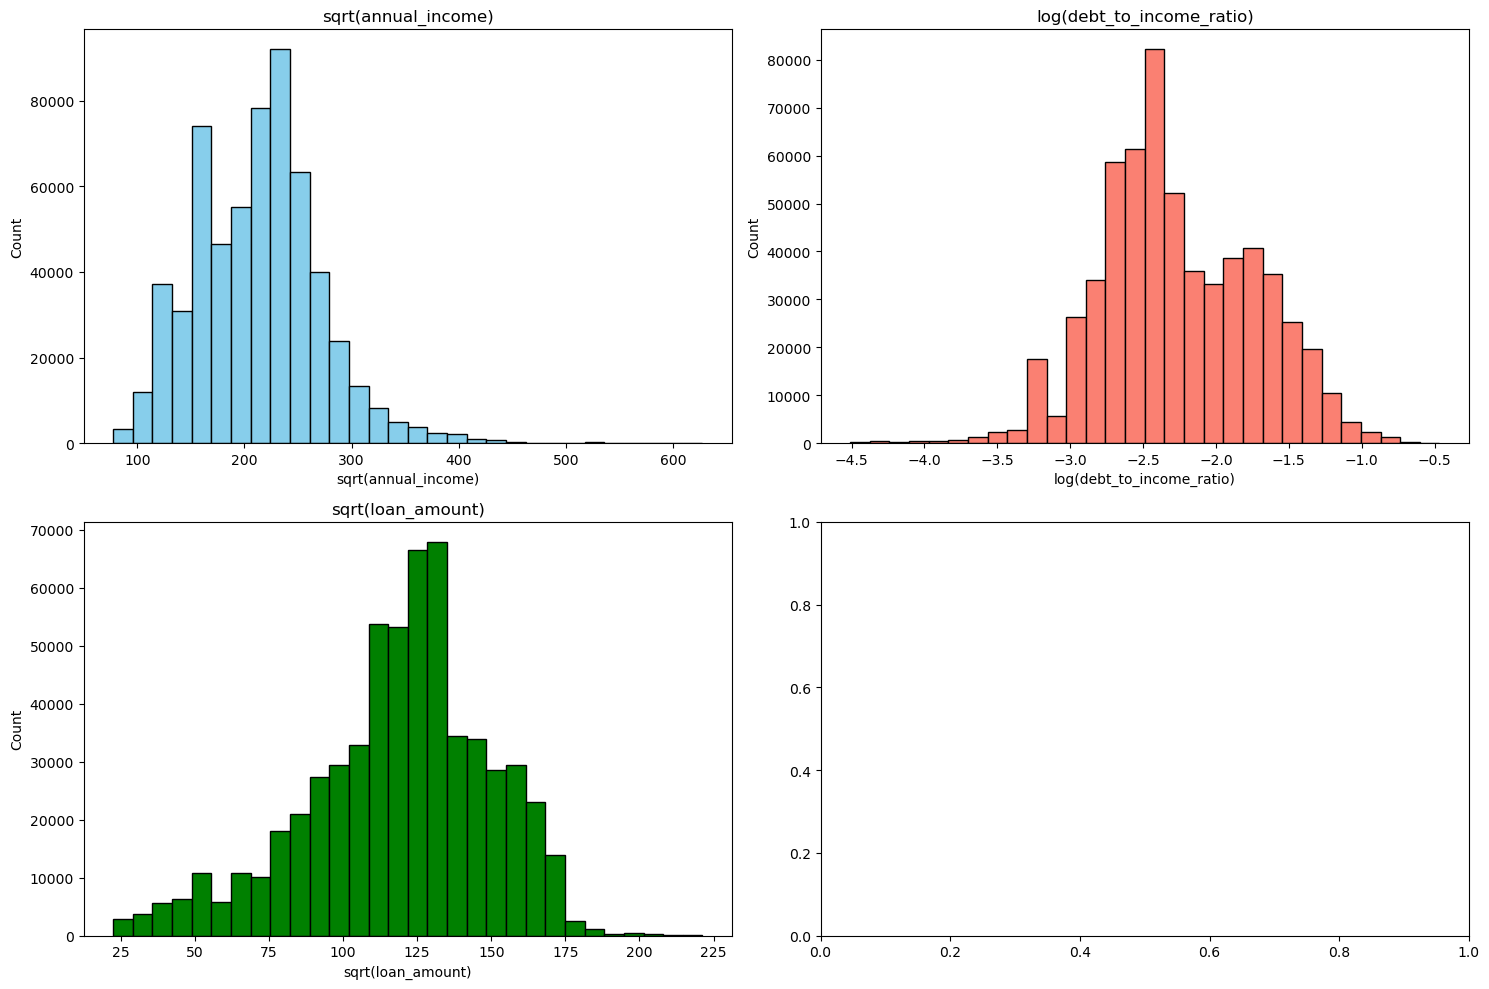

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

X_sqrt_income = np.sqrt(X['annual_income'])
axs[0,0].hist(X_sqrt_income, bins=30, color='skyblue', edgecolor='black')
axs[0,0].set_title('sqrt(annual_income)')
axs[0,0].set_xlabel('sqrt(annual_income)')
axs[0,0].set_ylabel('Count')

X_log_dti = np.log(X['debt_to_income_ratio'])
axs[0,1].hist(X_log_dti, bins=30, color='salmon', edgecolor='black')
axs[0,1].set_title('log(debt_to_income_ratio)')
axs[0,1].set_xlabel('log(debt_to_income_ratio)')
axs[0,1].set_ylabel('Count')

X_loan_amount = np.sqrt(X['loan_amount'])
axs[1,0].hist(X_loan_amount, bins=30, color='green', edgecolor='black')
axs[1,0].set_title('sqrt(loan_amount)')
axs[1,0].set_xlabel('sqrt(loan_amount)')
axs[1,0].set_ylabel('Count')

plt.tight_layout()
plt.show()


### Feature Engineering Notes

**Important:** During experimentation, many new features were tested (ratio features, multiplication features), but they did not improve results - instead, they worsened model performance.

**Experimentation Process:**
- Tested ratio features: `loan_amount / annual_income`, `credit_score / annual_income`, etc.
- Tested multiplication features: `loan_amount * interest_rate`, `loan_amount * credit_score`, etc.
- **Result:** All new features decreased model performance (from 0.9222 to 0.9218-0.9220)
- **Problem:** New features introduced noise and overfitting without adding meaningful information

**Conclusion:** New features do not add information, they only increase noise and overfitting. Therefore, the final version uses only basic transformations:
- `sqrt(annual_income)` - distribution normalization
- `log(debt_to_income_ratio)` - distribution normalization
- OneHot encoding for categorical features
- StandardScaler for numerical features

All additional features are commented out in the code below.


In [6]:
sqrt_pipeline = Pipeline([
    ('sqrt', FunctionTransformer(np.sqrt)),
    ('scaler', StandardScaler())
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log)),
    ('scaler', StandardScaler())
])

def column_ratio(X):
    if isinstance(X, pd.DataFrame):
        X = X.values
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
     col1, col2 = feature_names_in
     return [f"{col1}_to_{col2}_ratio"]

def column_multiplication(X):
    if isinstance(X, pd.DataFrame):
        X = X.values
    return X[:, [0]] * X[:, [1]]

def multiplication_name(function_transformer, feature_names_in):
     col1, col2 = feature_names_in
     return [f"{col1}_times_{col2}"]

ratio_pipeline = Pipeline([
    ('ratio', FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
    ('scaler', StandardScaler())
])

multiplication_pipeline = Pipeline([
    ('multiplication', FunctionTransformer(column_multiplication, feature_names_out=multiplication_name)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        #('ratio1', ratio_pipeline, ['loan_amount', 'annual_income']),
        #('ratio2', ratio_pipeline, ['credit_score', 'annual_income']),
        #('ratio3', ratio_pipeline, ['credit_score', 'interest_rate']),
        #('ratio4', ratio_pipeline, ['debt_to_income_ratio', 'annual_income']),
        #('multiplication1', multiplication_pipeline, ['loan_amount', 'interest_rate']),
        #('multiplication2', multiplication_pipeline, ['loan_amount', 'credit_score']),
        #('multiplication3', multiplication_pipeline, ['loan_amount', 'debt_to_income_ratio']),
        ('sqrt', sqrt_pipeline, ['annual_income']),
        ('log', log_pipeline, ['debt_to_income_ratio']),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features.drop(['annual_income', 'debt_to_income_ratio']))
    ]
)

preprocessor.set_output(transform="pandas")

,transformers,"[('sqrt', ...), ('log', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,func,<ufunc 'sqrt'>
,inverse_func,None
,validate,False


## Base Model Training and Evaluation

Train multiple base models and evaluate their performance. Use RandomizedSearchCV for hyperparameter tuning. The best performing models will be selected for the final meta-model ensemble.

### Models Tested:
1. **Logistic Regression** - Baseline linear model
2. **Random Forest** - Ensemble of decision trees
3. **XGBoost** - Gradient boosting framework
4. **LightGBM** - Fast gradient boosting
5. **CatBoost** - Gradient boosting with categorical feature handling

In [7]:
def report(model):
    y_pred = model.predict(X_val)
    y_probs = model.predict_proba(X_val)[:, 1]

    cf = confusion_matrix(y_val, y_pred)
    cl_report = classification_report(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_probs)
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    print(f" ROC AUC: {roc_auc:.4f}")

lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=3000))
])

### Logistic Regression

Baseline model with hyperparameter tuning.


In [8]:
lr_params = {
    'model__C': np.logspace(-4, 2, 20),
    'model__class_weight': [None, 'balanced']
}

lr_rs = RandomizedSearchCV(lr_model, param_distributions=lr_params, n_iter=20, cv=3, scoring='roc_auc', random_state=42)
lr_rs.fit(X_train, y_train)
report(lr_rs.best_estimator_)
print(lr_rs.best_params_)


[[18594  5306]
 [12172 82727]]
              precision    recall  f1-score   support

         0.0       0.60      0.78      0.68     23900
         1.0       0.94      0.87      0.90     94899

    accuracy                           0.85    118799
   macro avg       0.77      0.82      0.79    118799
weighted avg       0.87      0.85      0.86    118799

 ROC AUC: 0.9089
{'model__class_weight': 'balanced', 'model__C': np.float64(0.615848211066026)}


### Random Forest

Ensemble of decision trees with hyperparameter optimization.


In [ ]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs = -1))
])

# rf_params = {
#     'model__n_estimators': [250, 350, 450, 600, 750],
#     'model__max_depth': [10, 16, 20, 24, 28],
#     'model__min_samples_split': [2, 4, 6, 8, 12],
#     'model__min_samples_leaf': [1, 2, 3, 5, 7],
#     'model__class_weight': ['balanced', None]
# }

rf_params = {
    'model__n_estimators': [450],
    'model__max_depth': [20],
    'model__min_samples_split': [np.int64(6)],
    'model__min_samples_leaf': [np.int64(3)],
    'model__class_weight': ['balanced']
}

rf_rs = RandomizedSearchCV(rf_model, param_distributions=rf_params, n_iter=1, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
rf_rs.fit(X_train, y_train)
report(rf_rs.best_estimator_)


[[17945  5955]
 [ 8545 86354]]
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71     23900
         1.0       0.94      0.91      0.92     94899

    accuracy                           0.88    118799
   macro avg       0.81      0.83      0.82    118799
weighted avg       0.88      0.88      0.88    118799

 ROC AUC: 0.9136


In [10]:
print(rf_rs.best_params_)

{'model__n_estimators': 450, 'model__min_samples_split': np.int64(6), 'model__min_samples_leaf': np.int64(3), 'model__max_depth': 20, 'model__class_weight': 'balanced'}


### XGBoost

Gradient boosting framework with extensive hyperparameter search.


In [ ]:
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Keeping old parameter grid for reference, commented out
# xgb_params = {
#     'model__n_estimators': [100, 200, 300, 400, 500],
#     'model__max_depth': [3, 5, 7, 10],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__subsample': [0.8, 0.9, 1.0],
#     'model__colsample_bytree': [0.8, 0.9, 1.0],
#     'model__min_child_weight': [1, 3, 5],
#     'model__scale_pos_weight': [1, 2, 4],
#     'model__gamma': [0, 0.1, 0.2],
#     'model__reg_alpha': [0, 0.1, 0.5],
#     'model__reg_lambda': [1, 1.5, 2]
# }

# Parameter grid with optimal parameters (ROC AUC: 0.9202)

xgb_params = {
    'model__n_estimators': [400],
    'model__max_depth': [3],
    'model__learning_rate': [0.2],
    'model__subsample': [0.9],
    'model__colsample_bytree': [1.0],
    'model__min_child_weight': [3],
    'model__scale_pos_weight': [1],
    'model__gamma': [0],
    'model__reg_alpha': [0.5],
    'model__reg_lambda': [1.5]
}

xgb_rs = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=1, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
xgb_rs.fit(X_train, y_train)
report(xgb_rs.best_estimator_)
print(xgb_rs.best_params_)

[[14441  9459]
 [ 1830 93069]]
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799

 ROC AUC: 0.9203
{'model__subsample': 0.9, 'model__scale_pos_weight': 1, 'model__reg_lambda': 1.5, 'model__reg_alpha': 0.5, 'model__n_estimators': 400, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


### LightGBM

Train and optimize LightGBM classifier for loan payback prediction.


In [12]:
lgbmc_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# lgbmc_params = {
#     'model__n_estimators': [400, 500, 600, 700, 800],
#     'model__max_depth': [7, 9, 11, 13, 15],
#     'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07],
#     'model__num_leaves': [100, 150, 200, 250, 300],
#     'model__subsample': [0.6, 0.7, 0.8, 0.9],
#     'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
#     'model__min_child_samples': [10, 20, 30, 50, 70],
#     'model__reg_alpha': [0, 0.5, 1, 2, 3],
#     'model__reg_lambda': [1, 2, 3, 5, 7, 10],
#     'model__scale_pos_weight': [2, 3, 4, 5, 6]
# }

lgbmc_params = {
    'model__n_estimators': [700],
    'model__max_depth': [7],
    'model__learning_rate': [0.07],
    'model__num_leaves': [150],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.6],
    'model__min_child_samples': [70],
    'model__reg_alpha': [2],
    'model__reg_lambda': [3],
    'model__scale_pos_weight': [3]
}

lgbmc_rs = RandomizedSearchCV(lgbmc_model, param_distributions=lgbmc_params, n_iter=1, cv=3, scoring='roc_auc', random_state=42)
lgbmc_rs.fit(X_train, y_train)
report(lgbmc_rs.best_estimator_)
print(lgbmc_rs.best_params_)

[[12577 11323]
 [  558 94341]]
              precision    recall  f1-score   support

         0.0       0.96      0.53      0.68     23900
         1.0       0.89      0.99      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.93      0.76      0.81    118799
weighted avg       0.91      0.90      0.89    118799

 ROC AUC: 0.9222
{'model__subsample': 0.8, 'model__scale_pos_weight': 3, 'model__reg_lambda': 3, 'model__reg_alpha': 2, 'model__num_leaves': 150, 'model__n_estimators': 700, 'model__min_child_samples': 70, 'model__max_depth': 7, 'model__learning_rate': 0.07, 'model__colsample_bytree': 0.6}


### CatBoost

Train CatBoost classifier. CatBoost handles categorical features natively and often performs well without extensive hyperparameter tuning.

**Note:** An attempt was made to tune CatBoost using RandomizedSearchCV, but this led to worse results (from 0.9226 to 0.9208) due to overfitting. Default CatBoost parameters showed the best result.

**Conclusion:** CatBoost works excellently "out of the box" and does not require tuning. More extensive tuning could potentially improve results, but requires significant time (1-2 hours), so default parameters are used in the final version.


In [13]:
catboost_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(random_state=42, verbose=False))
])

catboost_model.fit(X_train, y_train)
report(catboost_model)


[[14861  9039]
 [ 2100 92799]]
              precision    recall  f1-score   support

         0.0       0.88      0.62      0.73     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.91    118799
   macro avg       0.89      0.80      0.84    118799
weighted avg       0.90      0.91      0.90    118799

 ROC AUC: 0.9226


## Ensemble Model: Meta-Model Optimization

Create an ensemble by combining predictions from multiple base models using optimized meta-models. Meta-models learn to combine base model predictions for improved performance.

### Experimentation Process and Challenges

During the development process, several ensemble approaches were tested:

**1. Stacking Approach:**
- Tested sklearn's `StackingClassifier` with various meta-learners
- **Result:** Performance degraded compared to individual base models
- **Problem:** Stacking introduced additional complexity without capturing useful interactions between models

**2. Blending Approach:**
- Tested weighted blending with Logistic Regression
- Tested simple averaging of predictions
- Tested optimized weights using scipy.optimize
- **Result:** All blending methods performed worse (0.9185-0.9189 ROC AUC) than the best base model (0.9226)
- **Problem:** Blending could not effectively combine the strengths of different models, and weaker models (like Random Forest) were dragging down the ensemble

**3. Meta-Model Approach (Selected):**
- Uses out-of-fold predictions from base models to train a second-level model
- Prevents data leakage by ensuring each prediction comes from a model that didn't see that sample during training
- **Result:** Achieved 0.9230 ROC AUC on validation set, improving from best base model (0.9226)
- **Why it works:** The meta-learner (XGBoost/LightGBM) learns optimal ways to combine base model predictions, capturing non-linear interactions

### Final Configuration

**Base Models Used:** Only the three strongest models are included in the meta-model:
- CatBoost (0.9226 ROC AUC) - best individual model
- LightGBM (0.9222 ROC AUC)
- XGBoost (0.9203 ROC AUC)

**Excluded Models:**
- Random Forest (0.9136 ROC AUC) - excluded as it performed significantly worse and was dragging down ensemble performance
- Logistic Regression (0.9089 ROC AUC) - too weak to contribute meaningfully

**Meta-Learners Tested:** Three meta-learners were tested:
- XGBoost (0.923031 ROC AUC) - best performance
- LightGBM (0.923016 ROC AUC)
- CatBoost - tested as it showed best performance as base model


### Base Model Predictions and XGBoost Meta-Model

Generate out-of-fold predictions from base models and train an XGBoost meta-model to combine them.


In [14]:
lgbm_best = lgbmc_rs.best_estimator_
xgb_best = xgb_rs.best_estimator_
lr_best = lr_rs.best_estimator_
catboost_best = catboost_model

lgbm_probs = cross_val_predict(lgbm_best, X_train, y_train, 
                               cv=5, method='predict_proba', n_jobs=-1)[:, 1]
xgb_probs = cross_val_predict(xgb_best, X_train, y_train, 
                              cv=5, method='predict_proba', n_jobs=-1)[:, 1]
catboost_probs = cross_val_predict(catboost_best, X_train, y_train, 
                                  cv=5, method='predict_proba', n_jobs=-1)[:, 1]

meta_X = np.column_stack([lgbm_probs, xgb_probs, catboost_probs])

meta_xgb = XGBClassifier(random_state=42)

# meta_xgb_params = {
#     'n_estimators': [150, 200, 250, 300, 350, 400],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
#     'subsample': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
#     'colsample_bytree': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
#     'min_child_weight': [1, 2, 3, 4, 5, 6],
#     'reg_alpha': [0, 0.05, 0.1, 0.2, 0.3, 0.5],
#     'reg_lambda': [1, 2, 3, 4, 5, 6, 7, 10],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
# } 

meta_xgb_params = {
    'subsample': [0.75],
    'reg_lambda': [10],
    'reg_alpha': [0.05],
    'n_estimators': [200],
    'min_child_weight': [3],
    'max_depth': [5],
    'learning_rate': [0.04],
    'gamma': [0.1],
    'colsample_bytree': [0.85]
}

meta_xgb_rs = RandomizedSearchCV(
    meta_xgb,
    param_distributions=meta_xgb_params,
    n_iter=1,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

meta_xgb_rs.fit(meta_X, y_train)
print("Best XGB meta-model parameters:", meta_xgb_rs.best_params_)
print("Best XGB meta-model ROC AUC:", meta_xgb_rs.best_score_)




Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best XGB meta-model parameters: {'subsample': 0.75, 'reg_lambda': 10, 'reg_alpha': 0.05, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.04, 'gamma': 0.1, 'colsample_bytree': 0.85}
Best XGB meta-model ROC AUC: 0.923077411947693


### LightGBM Meta-Model

Train a LightGBM meta-model as an alternative to XGBoost for combining base model predictions.


In [15]:
meta_lgbm = LGBMClassifier(random_state=42, verbose=-1)
# meta_lgbm_params = {
#     'n_estimators': [200, 300, 400, 500],
#     'max_depth': [3, 4, 5, 6, 7],
#     'learning_rate': [0.01, 0.02, 0.03, 0.05],
#     'num_leaves': [15, 31, 50, 70, 100],
#     'subsample': [0.7, 0.75, 0.8, 0.85, 0.9],
#     'colsample_bytree': [0.7, 0.75, 0.8, 0.85, 0.9],
#     'min_child_samples': [10, 20, 30, 50, 70],
#     'reg_alpha': [0, 0.1, 0.3, 0.5, 1],
#     'reg_lambda': [1, 2, 3, 5, 7, 10]
# }

meta_lgbm_params = {
    'n_estimators': [500],
    'max_depth': [5],
    'learning_rate': [0.02],
    'num_leaves': [15],
    'subsample': [0.85],
    'colsample_bytree': [0.85],
    'min_child_samples': [10],
    'reg_alpha': [0.1],
    'reg_lambda': [3]
}

meta_lgbm_rs = RandomizedSearchCV(
    meta_lgbm,
    param_distributions=meta_lgbm_params,
    n_iter=100,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

meta_lgbm_rs.fit(meta_X, y_train)
print("Best LGBM meta-model parameters:", meta_lgbm_rs.best_params_)
print("Best LGBM meta-model ROC AUC:", meta_lgbm_rs.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\rosts\miniconda3\envs\hml\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best LGBM meta-model parameters: {'subsample': 0.85, 'reg_lambda': 3, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.85}
Best LGBM meta-model ROC AUC: 0.923061713510893


### CatBoost Meta-Model

Train a CatBoost meta-model as an alternative to XGBoost and LightGBM for combining base model predictions. CatBoost showed the best performance as a base model, so it may also work well as a meta-learner.


In [ ]:
meta_catboost = CatBoostClassifier(random_state=42, verbose=False)
meta_catboost.fit(meta_X, y_train)

meta_catboost_scores = cross_val_score(
    meta_catboost, 
    meta_X, 
    y_train, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

print("CatBoost Meta-model ROC AUC (CV):", meta_catboost_scores.mean())
print("CatBoost Meta-model ROC AUC (std):", meta_catboost_scores.std())


CatBoost Meta-model ROC AUC (CV): 0.9222416193712512
CatBoost Meta-model ROC AUC (std): 0.0010065573153085602


### Meta-Model Validation

Evaluate meta-models on the validation set to compare their performance with base models and select the best approach.


In [17]:
lgbm_probs_val = lgbm_best.predict_proba(X_val)[:, 1]
xgb_probs_val = xgb_best.predict_proba(X_val)[:, 1]
catboost_probs_val = catboost_best.predict_proba(X_val)[:, 1]

meta_X_val = np.column_stack([lgbm_probs_val, xgb_probs_val, catboost_probs_val])

meta_xgb_probs_val = meta_xgb_rs.best_estimator_.predict_proba(meta_X_val)[:, 1]
meta_lgbm_probs_val = meta_lgbm_rs.best_estimator_.predict_proba(meta_X_val)[:, 1]
meta_catboost_probs_val = meta_catboost.predict_proba(meta_X_val)[:, 1]

meta_xgb_score_val = roc_auc_score(y_val, meta_xgb_probs_val)
meta_lgbm_score_val = roc_auc_score(y_val, meta_lgbm_probs_val)
meta_catboost_score_val = roc_auc_score(y_val, meta_catboost_probs_val)

print(f"Meta-models on validation:")
print(f"  XGB Meta-model:      {meta_xgb_score_val:.6f}")
print(f"  LGBM Meta-model:     {meta_lgbm_score_val:.6f}")
print(f"  CatBoost Meta-model: {meta_catboost_score_val:.6f}")
print(f"\nBase models on validation:")
print(f"  CatBoost: {roc_auc_score(y_val, catboost_probs_val):.6f}")
print(f"  LGBM:     {roc_auc_score(y_val, lgbm_probs_val):.6f}")
print(f"  XGB:      {roc_auc_score(y_val, xgb_probs_val):.6f}")

c:\Users\rosts\miniconda3\envs\hml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Meta-models on validation:
  XGB Meta-model:      0.923031
  LGBM Meta-model:     0.923016
  CatBoost Meta-model: 0.922411

Base models on validation:
  CatBoost: 0.922630
  LGBM:     0.922160
  XGB:      0.920346


## Final Predictions and Submission

Train final models on the full training dataset and generate predictions for the test set. The meta-model is retrained using out-of-fold predictions from base models to avoid data leakage.


In [ ]:
lgbm_best.fit(X, y)
xgb_best.fit(X, y)
catboost_best.fit(X, y)

lgbm_probs_test = lgbm_best.predict_proba(X_test)[:, 1]
xgb_probs_test = xgb_best.predict_proba(X_test)[:, 1]
catboost_probs_test = catboost_best.predict_proba(X_test)[:, 1]

meta_X_test = np.column_stack([lgbm_probs_test, xgb_probs_test, catboost_probs_test])

lgbm_probs_full = cross_val_predict(lgbm_best, X, y, cv=5, method='predict_proba', n_jobs=-1)[:, 1]
xgb_probs_full = cross_val_predict(xgb_best, X, y, cv=5, method='predict_proba', n_jobs=-1)[:, 1]
catboost_probs_full = cross_val_predict(catboost_best, X, y, cv=5, method='predict_proba', n_jobs=-1)[:, 1]

meta_X_full = np.column_stack([lgbm_probs_full, xgb_probs_full, catboost_probs_full])

final_meta_model = meta_xgb_rs.best_estimator_
final_meta_model.fit(meta_X_full, y)

final_predictions = final_meta_model.predict_proba(meta_X_test)[:, 1]

submission = pd.DataFrame({
    'id': index_test,
    'loan_paid_back': final_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission saved!")